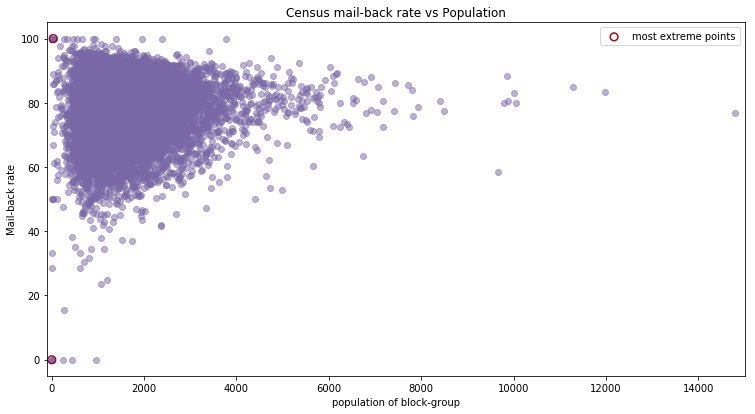

In [1]:
import pymc as pm
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
%matplotlib inline

figsize(12.5, 6.5)
data = np.genfromtxt("./data/census_data.csv", skip_header=1, delimiter=",")
plt.scatter(data[:, 1], data[:, 0], alpha=0.5, c="#7A68A6")

i_min = np.argmin(data[:, 0])
i_max = np.argmax(data[:, 0])
plt.scatter([data[i_min, 1], data[i_max, 1]],
            [data[i_min, 0], data[i_max, 0]],
            s=60, marker="o", facecolors="none",
            edgecolors="#A60628", linewidths=1.5,
            label="most extreme points")

plt.title("Census mail-back rate vs Population")
plt.ylabel("Mail-back rate")
plt.xlabel("population of block-group")
plt.xlim(-100, 15e3)
plt.ylim(-5, 105)
plt.legend(scatterpoints=1);

In [2]:
%run top_showerthoughts_submissions.py 2

print("Post contents: \n")
print(top_post)

Version 3.6.0 of praw is outdated. Version 5.2.0 was released Tuesday October 24, 2017.
Post contents: 

GameStop, where you either get 1 game for $60 or $1 for 60 games.


In [3]:
n_submissions = len(votes)
submissions = np.random.randint( n_submissions, size=4)
print("Some Submissions (out of %d total) \n-----------"%n_submissions)
for i in submissions:
    print('"' + contents[i] + '"')
    print("upvotes/downvotes: ",votes[i,:], "\n")

Some Submissions (out of 5 total) 
-----------
"You know you're getting old when your emergency contact goes from being your parents to your children."
upvotes/downvotes:  [29  4] 

"You know you're getting old when your emergency contact goes from being your parents to your children."
upvotes/downvotes:  [29  4] 

"Playing golf is a lot like playing fetch with yourself"
upvotes/downvotes:  [39  6] 

"Playing golf is a lot like playing fetch with yourself"
upvotes/downvotes:  [39  6] 



In [4]:
import pymc as pm

def posterior_upvote_ratio(upvotes, downvotes, samples=20000):
    N = upvotes + downvotes
    upvote_ratio = pm.Uniform("upvote_ratio", 0, 1)
    observations = pm.Binomial("obs", N, upvote_ratio, value=upvotes, observed=True)
    map_ = pm.MAP([upvote_ratio, observations]).fit()
    mcmc = pm.MCMC([upvote_ratio, observations])
    mcmc.sample(samples, samples / 4)
    return mcmc.trace("upvote_ratio")[:]

 [-----------------100%-----------------] 20000 of 20000 complete in 1.2 sec

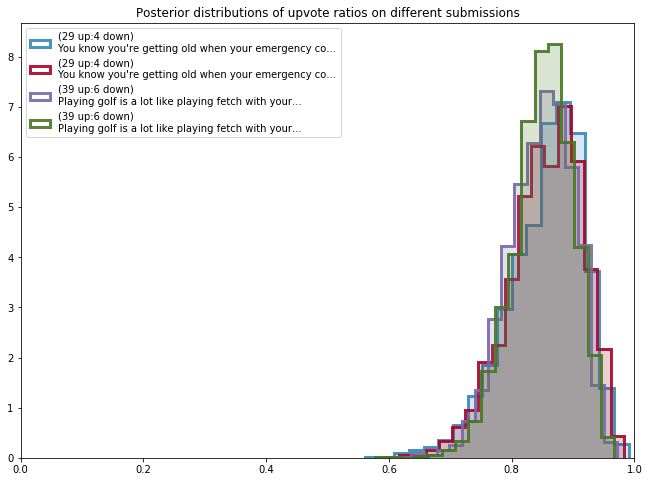

In [5]:
figsize(11., 8)
posteriors = []
colours = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#CF4457"]
for i in range(len(submissions)):
    j = submissions[i]
    posteriors.append(posterior_upvote_ratio(votes[j, 0], votes[j, 1]))
    plt.hist(posteriors[i], bins=18, normed=True, alpha=.9,
             histtype="step", color=colours[i % 5], lw=3,
             label='(%d up:%d down)\n%s...' % (votes[j, 0], votes[j, 1], contents[j][:50]))
    plt.hist(posteriors[i], bins=18, normed=True, alpha=.2,
             histtype="stepfilled", color=colours[i], lw=3, )

plt.legend(loc="upper left")
plt.xlim(0, 1)
plt.title("Posterior distributions of upvote ratios on different submissions")

[3 2 1 0] [0.73968294652740008, 0.74938092672174983, 0.75855286278891643, 0.76317270568969808]


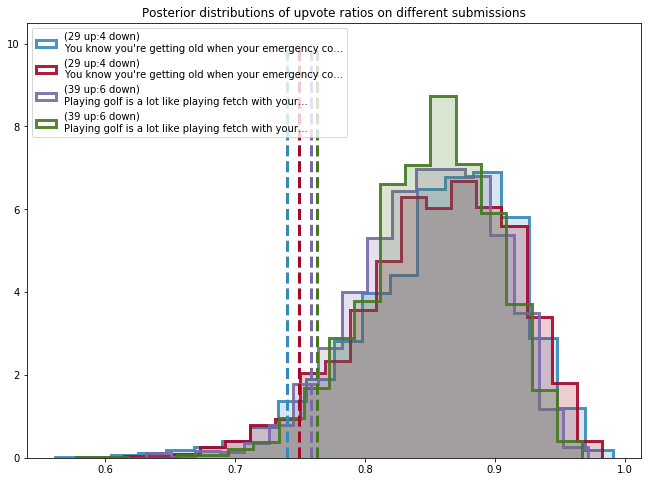

In [6]:
N = posteriors[0].shape[0]
lower_limits = []

for i in range(len(submissions)):
    j = submissions[i]
    plt.hist(posteriors[i], bins=20, normed=True, alpha=.9,
             histtype="step", color=colours[i], lw=3,
             label='(%d up:%d down)\n%s...' % (votes[j, 0], votes[j, 1], contents[j][:50]))
    plt.hist(posteriors[i], bins=20, normed=True, alpha=.2,
             histtype="stepfilled", color=colours[i], lw=3, )
    v = np.sort(posteriors[i])[int(0.05 * N)]
    # plt.vlines( v, 0, 15 , color = "k", alpha = 1, linewidths=3 )
    plt.vlines(v, 0, 10, color=colours[i], linestyles="--", linewidths=3)
    lower_limits.append(v)
    plt.legend(loc="upper left")

plt.legend(loc="upper left")
plt.title("Posterior distributions of upvote ratios on different submissions");
order = np.argsort(-np.array(lower_limits))
print(order, lower_limits)

In [7]:
def intervals(u, d):
    a = 1. + u
    b = 1. + d
    mu = a / (a + b)
    std_err = 1.65 * np.sqrt((a * b) / ((a + b) ** 2 * (a + b + 1.)))
    return (mu, std_err)

print("Approximate lower bounds:")
posterior_mean, std_err = intervals(votes[:, 0], votes[:, 1])
lb = posterior_mean - std_err
print(lb)
print("\n")
print("Top 40 Sorted according to approximate lower bounds:")
print("\n")
order = np.argsort(-lb)
ordered_contents = []
for i in order[:40]:
    ordered_contents.append(contents[i])
    print(votes[i, 0], votes[i, 1], contents[i])
    print("-------------")

Approximate lower bounds:
[ 0.76627386  0.7609129   0.7831651   0.64814153  0.58991998]


Top 40 Sorted according to approximate lower bounds:


22 2 Imagine that in our natural state we were always high, and there was a drug that made us feel sober
-------------
39 6 Playing golf is a lot like playing fetch with yourself
-------------
29 4 You know you're getting old when your emergency contact goes from being your parents to your children.
-------------
20 5 Parades would be much more enjoyable if they were done at or above the speed limit.
-------------
18 6 Ginger powder and cinnamon powder are just sawdust. Very specific sawdust.
-------------


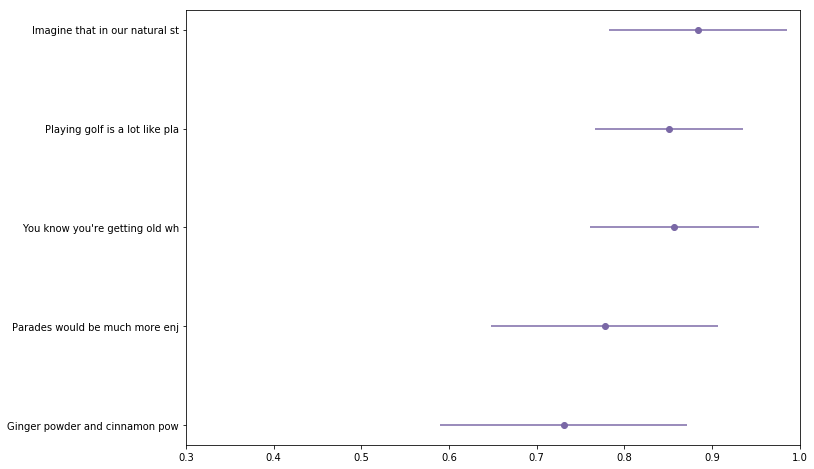

In [8]:
r_order = order[::-1][-40:]
plt.errorbar(posterior_mean[r_order], np.arange(len(r_order)),
             xerr=std_err[r_order], capsize=0, fmt="o",
             color="#7A68A6")
plt.xlim(0.3, 1)
plt.yticks(np.arange(len(r_order) - 1, -1, -1), map(lambda x: x[:30].replace("\n", ""), ordered_contents));